# Sentiment Analysis on Textual Data (Tweets / Reviews)

This notebook walks through a complete, practical pipeline for **sentiment analysis** using NLP techniques. It includes:
- Data loading (CSV)
- Text cleaning & preprocessing
- Exploratory Data Analysis (basic)
- Two modelling approaches:
  1. Classical ML: TF-IDF + Logistic Regression
  2. Transformer-based: Hugging Face `distilbert` (optional, requires internet)
- Evaluation (accuracy, F1, confusion matrix)
- Example inference / saving model

Instructions:
1. Upload your CSV (with columns `text` and `label`) to the Colab/Jupyter runtime. If your dataset has different column names, update `TEXT_COL` and `LABEL_COL`.
2. Run cells sequentially (or use **Runtime → Run all** in Colab).

If you don't have a dataset, the notebook generates a small sample dataset for demonstration.

In [1]:
### Install required packages (run once in Colab/Jupyter)
import sys
IN_COLAB = 'jupyter_notebook' in sys.modules
if IN_COLAB:
    get_ipython().system('pip install -q transformers datasets scikit-learn matplotlib seaborn nltk sentencepiece')
else:
    print('If running locally, ensure you have: transformers, datasets, scikit-learn, matplotlib, seaborn, nltk installed')


If running locally, ensure you have: transformers, datasets, scikit-learn, matplotlib, seaborn, nltk installed


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NASHEER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1) Load your data
Replace the filename below with your CSV file. The CSV should have at least two columns: `text` (the text) and `label` (sentiment label, e.g., 0/1 or negative/positive).


In [11]:
# Step 1 — Load dataset safely
try:
    # Make sure to use quotes around the file name
    df = pd.read_csv("sentiment_dataset_500.csv")
    print("Loaded dataset successfully.")
except Exception as e:
    print("Could not load dataset:", e)
    print("A small demo dataset will be created instead.")
    df = pd.DataFrame({
        'text': [
            'I love this product, it is amazing!',
            'This is the worst experience I ever had.',
            'Not bad, could be better.',
            'Absolutely fantastic! Highly recommend it.',
            'Terrible service, will not return.'
        ],
        'label': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']
    })

# Step 2 — Clean and standardize column names
df.columns = [c.strip().lower() for c in df.columns]

# Step 3 — Automatically rename if needed
df = df.rename(columns={
    **({c: 'text' for c in df.columns if 'text' in c.lower() or 'review' in c.lower() or 'tweet' in c.lower()}),
    **({c: 'label' for c in df.columns if c.lower() in ['label', 'sentiment', 'target', 'sentiment_label']})
})

# Step 4 — Define column variables safely
TEXT_COL = 'text'
LABEL_COL = 'label'

# Step 5 — Verify and fix if column names differ
if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
    possible_text = [c for c in df.columns if 'review' in c.lower() or 'tweet' in c.lower() or 'text' in c.lower()]
    possible_label = [c for c in df.columns if c.lower() in ['label', 'sentiment', 'target', 'sentiment_label']]
    if possible_text:
        TEXT_COL = possible_text[0]
    if possible_label:
        LABEL_COL = possible_label[0]

print(f"Using TEXT_COL = '{TEXT_COL}' and LABEL_COL = '{LABEL_COL}'")

# Step 6 — Select and clean the final columns
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)

# Step 7 — Preview the data
print(df.head())


Loaded dataset successfully.
Using TEXT_COL = 'text' and LABEL_COL = 'label'
                                         text     label
0  Terrible experience, not worth it. #review  Negative
1       Absolutely fantastic service. #review  Positive
2        It’s okay, nothing special. #opinion   Neutral
3         Not bad, not great either. #thought   Neutral
4          Not bad, not great either. #review   Neutral


## 2) Quick EDA
Check class balance and some example texts.

In [12]:
print('Class distribution:')
display(df[LABEL_COL].value_counts())

print('\nSample texts:')
for i, row in df.sample(min(5, len(df))).iterrows():
    print('-', row[TEXT_COL][:150])


Class distribution:


label
Negative    175
Neutral     169
Positive    156
Name: count, dtype: int64


Sample texts:
- It works fine for now. #comment
- I hate this product. #review
- Completely useless and buggy. #review
- Really enjoyed using it. #opinion
- Not bad, not great either. #thought


## 3) Text cleaning & preprocessing
We will lowercase, remove URLs, mentions, hashtags (optional), punctuation, and stopwords.

In [13]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+', '', s)          # remove urls
    s = re.sub(r'@\w+', '', s)                    # remove mentions
    s = re.sub(r'#', '', s)                        # remove hash symbol only
    s = re.sub(r'[^a-z0-9\s]', ' ', s)            # keep alphanumeric
    s = re.sub(r'\s+', ' ', s).strip()
    tokens = [w for w in s.split() if w not in STOPWORDS]
    return ' '.join(tokens)

df['clean_text'] = df[TEXT_COL].astype(str).apply(clean_text)
df[['clean_text']].head()


,clean_text
0,terrible experience worth review
1,absolutely fantastic service review
2,okay nothing special opinion
3,bad great either thought
4,bad great either review


## 4) Train/test split

In [14]:
X = df['clean_text']
y = df[LABEL_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(df[LABEL_COL].unique())>1 else None)
print('Train size:', len(X_train), 'Test size:', len(X_test))


Train size: 400 Test size: 100


## 5) Approach A — TF-IDF + Logistic Regression (fast, strong baseline)

Accuracy: 1.0
F1: 1.0

Classification report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        35
     Neutral       1.00      1.00      1.00        34
    Positive       1.00      1.00      1.00        31

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



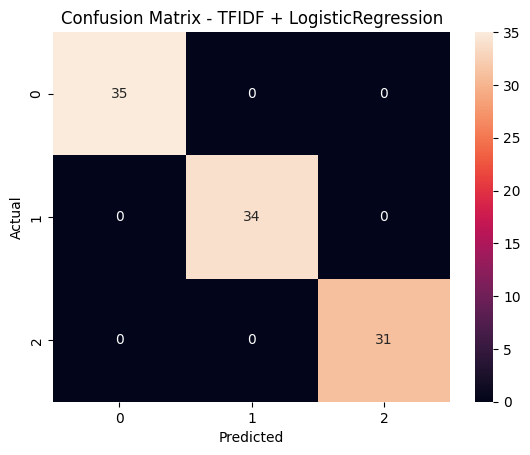

Saved TF-IDF pipeline as tfidf_logreg_pipeline.joblib


In [15]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
clf = LogisticRegression(max_iter=1000)
pipe_tfidf = Pipeline([('tfidf', tfidf), ('clf', clf)])
pipe_tfidf.fit(X_train, y_train)
preds = pipe_tfidf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, preds))
print('F1:', f1_score(y_test, preds, average='weighted'))
print('\nClassification report:\n', classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix - TFIDF + LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
joblib.dump(pipe_tfidf, 'tfidf_logreg_pipeline.joblib')
print('Saved TF-IDF pipeline as tfidf_logreg_pipeline.joblib')


## 6) Approach B — Transformer-based classifier (optional / stronger)
This uses Hugging Face `transformers`. It requires internet to download model weights and can be slow without a GPU. If you are in Colab, enable GPU (Runtime → Change runtime type → GPU).
We'll use the `pipeline` API for simplicity.


In [16]:
try:
    from transformers import pipeline
    hf_pipe = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
    print('Hugging Face pipeline is ready. Example:')
    print(hf_pipe('I love this!'))
except Exception as e:
    print('Transformer pipeline not available (offline or package missing). To enable, install transformers and ensure internet access).')
    hf_pipe = None


Transformer pipeline not available (offline or package missing). To enable, install transformers and ensure internet access).


## 7) Quick inference examples
Try on test set (TF-IDF model) and, if available, transformer model.

In [17]:
sample_texts = X_test.sample(min(5, len(X_test)))
print('TF-IDF Predictions:')
for t in sample_texts:
    print('-', t)
    print('->', pipe_tfidf.predict([t])[0])

if hf_pipe is not None:
    print('\nTransformer predictions:')
    for t in sample_texts:
        print('-', t)
        print('->', hf_pipe(t))


TF-IDF Predictions:
- satisfied purchase thought
-> Positive
- bad great either review
-> Neutral
- really disappointed thought
-> Negative
- shipping took forever review
-> Negative
- quality awful feedback
-> Negative


## 8) Next steps and improvements
- Hyperparameter tuning (`GridSearchCV` / `RandomizedSearchCV`) for TF-IDF and classifier.
- Use class weighting or oversampling (SMOTE) for imbalanced classes.
- Fine-tune transformer models on your dataset for best results.
- Add explainability (LIME, SHAP) for model interpretations.
- Deploy model as API (FastAPI) or dashboard (Streamlit, Dash).
